In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

import umap
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)

from scipy.stats import chi2, linregress
from scipy.stats.mstats import winsorize

from collections import Counter

# For Alpaca API
from datetime import datetime
from zoneinfo import ZoneInfo

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.stock import StockHistoricalDataClient

from alpaca.data.requests import (
    StockBarsRequest
)

from alpaca.data.enums import Adjustment

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

# For API Keys
import os
from dotenv import load_dotenv

In [2]:
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [3]:
ticker_subsets = {
    'US_Equity': ['SPY', 'QQQ', 'IWM', 'DIA'],
    'Defensive_Sectors': ['XLP', 'XLV', 'XLU'],
    'Global_Equities': ['EEM', 'EFA', 'FXI', 'EWZ'],
    'Currencies': ['UUP', 'FXY', 'FXF', 'FXE', 'FXA', 'FXC']
}

all_tickers = sum(ticker_subsets.values(), [])

In [4]:
# Alpaca Data Load
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# alpaca has no older data than 2016
earliest_date = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
last_date = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

req = StockBarsRequest(
    symbol_or_symbols = all_tickers, 
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,  
    end = last_date,                  
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs


In [5]:
print("Total NANs:", df_adj.pivot(columns="symbol").isna().sum().sum())

Total NANs: 0


In [6]:
# Trend feature functions
def compute_trend_features(df):
    df = df.sort_index()
    df['ret_5d'] = df['close'].pct_change(5)
    df['ret_20d'] = df['close'].pct_change(20)
    df['ma_200'] = df['close'].rolling(200).mean()
    df['rsi_14'] = compute_rsi(df['close'], 14)
    return df

def compute_rsi(series, period):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.ewm(com=period - 1, min_periods=period).mean()
    ma_down = down.ewm(com=period - 1, min_periods=period).mean()
    rs = ma_up / ma_down
    return 100 - (100 / (1 + rs))

# Apply feature extraction
features_by_subset = {}
for subset, tickers in ticker_subsets.items():
    df_subset = df_adj[df_adj['symbol'].isin(tickers)].copy()
    df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
    df_feat = df_feat.droplevel(0)  # remove groupby index level
    df_feat = df_feat.dropna()
    features_by_subset[subset] = df_feat

C:\Users\sergi\AppData\Local\Temp\ipykernel_2832\958094803.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
C:\Users\sergi\AppData\Local\Temp\ipykernel_2832\958094803.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
C:\Users\sergi\AppData\Local\Temp\ipykernel_2832\958094803.p

In [7]:
# Combine all subsets
df_all = pd.concat(features_by_subset.values(), axis=0)
df_all = df_all.sort_index()

# Pivot wide
pivot_cols = ['ret_5d', 'ret_20d', 'rsi_14']
df_pivot = df_all.pivot_table(index=df_all.index, columns='symbol', values=pivot_cols)
df_pivot = df_pivot.dropna()

# Final smoothed 10 features
df_features = pd.DataFrame(index=df_pivot.index)

# 1. Mean 5-day return across equity indices
df_features['us_equity_returns_5d_avg'] = df_pivot['ret_5d'][['SPY', 'QQQ', 'IWM', 'DIA']].mean(axis=1)


# 2. US Equity Indices momentum slope: slope of 10-day returns linear fit
def slope_of_returns(series):
    x = np.arange(len(series))
    if len(series) < 10 or series.isnull().any():
        return np.nan
    slope, _, _, _, _ = linregress(x, series)
    return slope

eq_mom_slope = pd.DataFrame(index=df_pivot.index)
for c in ['SPY', 'QQQ', 'IWM', 'DIA']:
    eq_mom_slope[c] = df_pivot['ret_5d'][c].rolling(window=10).apply(slope_of_returns, raw=False)

df_features['us_equity_momentum_slope'] = eq_mom_slope.mean(axis=1)

# 3. Defensive sector RSI difference: mean RSI of defensive sectors minus mean RSI of US and global equity indices
df_features['equity_defensive_vs_broad_rsi_14d_spread'] = df_pivot['rsi_14'][['XLP', 'XLV', 'XLU']].mean(axis=1) -\
                                  df_pivot['rsi_14'][['SPY', 'QQQ', 'IWM', 'DIA', 'EEM', 'EFA', 'FXI', 'EWZ']].mean(axis=1)

# 4. Global mean RSI across global equities (smooth replacement)
df_features['global_equity_rsi_14d_avg'] = df_pivot['rsi_14'][['EEM', 'EFA', 'FXI', 'EWZ']].mean(axis=1)

# 5. Defensive safe-haven currencies against more cyclically-oriented "risk-on" currencies
df_features['safe_vs_risk_currencies_returns_5d_spread'] = df_pivot['ret_20d'][['UUP', 'FXY', 'FXF']].mean(axis=1) - \
                                      df_pivot['ret_20d'][['FXE', 'FXA', 'FXC']].mean(axis=1)

# Drop any rows with NaNs introduced by rolling window
df_features = df_features.dropna()

# Updated final features dataframe
df_pivot_clean = df_features.copy()

In [8]:
# clip 1% and 99% quantiles to reduce outliers
for col in df_pivot_clean.columns:
    # Winsorize at the 0+limit% and 100-limit% quantiles
    df_pivot_clean[col] = winsorize(df_pivot_clean[col], limits=[0.01, 0.01])

## Expermient deleting covid, same labels?

In [9]:
# cut covid to see if the crash deviates to much our regimes
post_covid = pd.Timestamp('2020-09-01', tz='UTC')
pre_covid = pd.Timestamp('2020-02-01', tz='UTC')
df_post_covid = df_pivot_clean[(df_pivot_clean.index < pre_covid)|(df_pivot_clean.index >= post_covid)]
df_post_covid.shape, df_pivot_clean.shape

((2034, 5), (2181, 5))

In [10]:
N_COMP=3
N_NEIG=15
MIN_D = 0.01
METRIC = "correlation" 
K = 4

RANDOM_STATE = 4

In [11]:
post_covid_scaled = StandardScaler().fit_transform(df_post_covid)
post_covid_X_umap = umap.UMAP(n_neighbors=N_NEIG, min_dist=MIN_D, n_components=N_COMP, metric=METRIC, random_state=RANDOM_STATE).fit_transform(post_covid_scaled)

post_covid_gmm = GaussianMixture(n_components=K, init_params="k-means++", random_state=RANDOM_STATE)
post_covid_gmm_labels = post_covid_gmm.fit_predict(post_covid_X_umap)

print({
    "silhouette": silhouette_score(post_covid_X_umap, post_covid_gmm_labels),
    "calinski_harabasz": calinski_harabasz_score(post_covid_X_umap, post_covid_gmm_labels),
    "davies_bouldin": davies_bouldin_score(post_covid_X_umap, post_covid_gmm_labels)
})

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'silhouette': 0.40255260467529297, 'calinski_harabasz': 2066.341064453125, 'davies_bouldin': 0.9480639394621295}


In [12]:
# original model
import joblib
# Get the project root (one level up from current working directory)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

os.makedirs(MODEL_DIR, exist_ok=True)

## If want to predict
# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_post_covid)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

In [13]:
print(post_covid_gmm_labels.shape, trend_gmm_labels.shape)

(2034,) (2034,)


In [14]:
# Define colors for plots
accent_colors = plt.cm.Accent(np.linspace(0, 1, K))
custom_cmap = "Accent"
cluster_palette = {i: accent_colors[i] for i in range(K)}

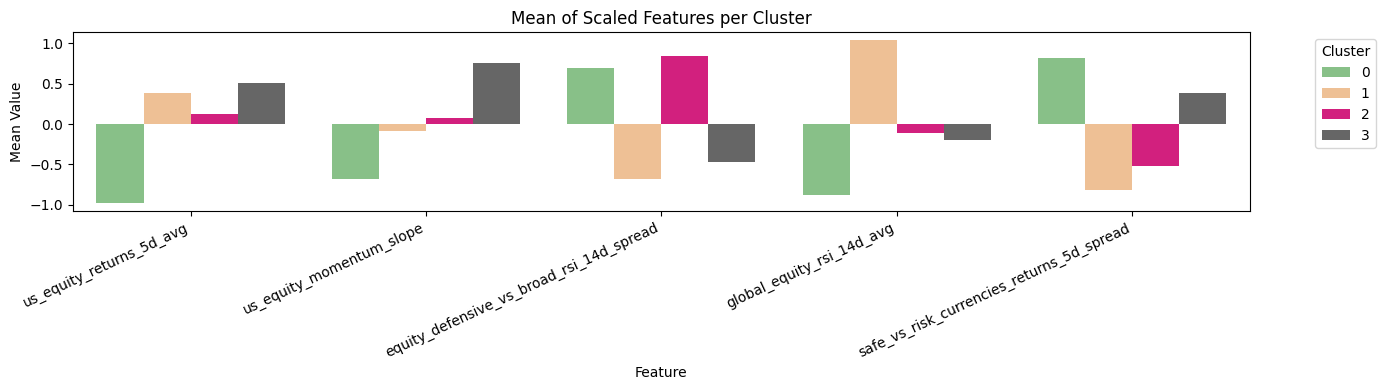

In [15]:
df_interpret = pd.DataFrame(post_covid_scaled, columns=df_post_covid.columns, index=df_post_covid.index)
# Assign cluster labels
df_interpret['Cluster'] = post_covid_gmm_labels

# Calculate mean value per feature per cluster
mean_per_cluster = df_interpret.groupby('Cluster').mean().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(14, 4))
sns.barplot(x='Feature', y='Mean', hue='Cluster', data=melted, palette=cluster_palette)

plt.title('Mean of Scaled Features per Cluster')
plt.ylabel('Mean Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=25, ha='right') # Rotate by 45 degrees, align right
plt.tight_layout()
plt.show()

# orginal -> post_covid
# 0 green "Bear" -> "Bear"
# 1 yellow "Bull" -> "Bull"
# 2 pink neutral-bearish US, global neutral, high defensive, low currency defensive (weak dollar) -> "Same/very similar interpretation"
# 3 grey bull US, strong momentum us, low defensive, bearish global, high currency defensive (strong dollar) -> "Same/very similar interpretation"

In [16]:
is_equal = (post_covid_gmm_labels == trend_gmm_labels)
print("% of day labelled as same cluster", round(is_equal.sum()/len(is_equal)*100, 2))

% of day labelled as same cluster 81.02


## One model trained with odd days, other with even, similar labels?

In [17]:
# Even rows: 0-based indexing, so rows 0, 2, 4, ... are even rows
even_rows = df_pivot_clean.iloc[::2]

# Odd rows: rows 1, 3, 5, ...
odd_rows = df_pivot_clean.iloc[1::2]

even_rows.shape, odd_rows.shape

((1091, 5), (1090, 5))

In [18]:
# scale data
orginal_trend_scaled = scaler.transform(df_pivot_clean)

# Apply UMAP transformation
orginal_trend_umap = umap_model.transform(orginal_trend_scaled)

# Predict clusters
orginal_trend_gmm_labels = gmm_model.predict(orginal_trend_umap)

In [19]:
RANDOM_STATE = 0
experiment = {'random_state': [],  'avg_abs_mean_diff': []}

In [20]:
# for _ in range(200):
#     even_scaled = StandardScaler().fit_transform(even_rows)
#     even_X_umap = umap.UMAP(n_neighbors=N_NEIG, min_dist=MIN_D, n_components=N_COMP, metric=METRIC, random_state=RANDOM_STATE).fit_transform(even_scaled)

#     even_gmm = GaussianMixture(n_components=K, init_params="k-means++", random_state=RANDOM_STATE)
#     even_gmm_labels = even_gmm.fit_predict(even_X_umap)

#     # print({
#     #     "silhouette": silhouette_score(even_X_umap, even_gmm_labels),
#     #     "calinski_harabasz": calinski_harabasz_score(even_X_umap, even_gmm_labels),
#     #     "davies_bouldin": davies_bouldin_score(even_X_umap, even_gmm_labels)
#     # })

#     odd_scaled = StandardScaler().fit_transform(odd_rows)
#     odd_X_umap = umap.UMAP(n_neighbors=N_NEIG, min_dist=MIN_D, n_components=N_COMP, metric=METRIC, random_state=RANDOM_STATE).fit_transform(odd_scaled)

#     odd_gmm = GaussianMixture(n_components=K, init_params="k-means++", random_state=RANDOM_STATE)
#     odd_gmm_labels = odd_gmm.fit_predict(odd_X_umap)

#     # print({
#     #     "silhouette": silhouette_score(odd_X_umap, odd_gmm_labels),
#     #     "calinski_harabasz": calinski_harabasz_score(odd_X_umap, odd_gmm_labels),
#     #     "davies_bouldin": davies_bouldin_score(odd_X_umap, odd_gmm_labels)
#     # })

#     ## EVEN
#     df_interpret = pd.DataFrame(even_scaled, columns=even_rows.columns, index=even_rows.index)
#     # Assign cluster labels
#     df_interpret['Cluster'] = even_gmm_labels

#     # Calculate mean value per feature per cluster
#     mean_per_cluster = df_interpret.groupby('Cluster').mean().T  # Transpose to get features as rows

#     # Melt the data for grouped barplot
#     melted_even = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean')
#     melted_even = melted_even.rename(columns={'index': 'Feature'})

#     ## ODD
#     df_interpret = pd.DataFrame(odd_scaled, columns=odd_rows.columns, index=odd_rows.index)
#     # Assign cluster labels
#     df_interpret['Cluster'] = odd_gmm_labels

#     # Calculate mean value per feature per cluster
#     mean_per_cluster = df_interpret.groupby('Cluster').mean().T  # Transpose to get features as rows

#     # Melt the data for grouped barplot
#     melted_odd = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean')
#     melted_odd = melted_odd.rename(columns={'index': 'Feature'})

#     ## original
#     df_interpret = pd.DataFrame(orginal_trend_scaled, columns=df_pivot_clean.columns, index=df_pivot_clean.index)
#     # Assign cluster labels
#     df_interpret['Cluster'] = orginal_trend_gmm_labels

#     # Calculate mean value per feature per cluster
#     mean_per_cluster = df_interpret.groupby('Cluster').mean().T  # Transpose to get features as rows

#     # Melt the data for grouped barplot
#     melted_original = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean')
#     melted_original = melted_original.rename(columns={'index': 'Feature'})



#     # merge them on Feature and Cluster
#     merged = melted_even.merge(
#         melted_odd, on=["Feature", "Cluster"], suffixes=("_even", "_odd")
#     ).merge(
#         melted_original, on=["Feature", "Cluster"]
#     )

#     # rename the original column for clarity
#     merged = merged.rename(columns={"Mean": "Mean_original"})

#     # compute absolute differences
#     merged["diff_even_odd"] = np.abs(merged["Mean_even"] - merged["Mean_odd"])
#     merged["diff_even_original"] = np.abs(merged["Mean_even"] - merged["Mean_original"])
#     merged["diff_odd_original"] = np.abs(merged["Mean_odd"] - merged["Mean_original"])

#     # compute average of these three per row
#     merged["avg_abs_diff_per_row"] = merged[["diff_even_odd", "diff_even_original", "diff_odd_original"]].mean(axis=1)

#     # compute the overall average absolute difference
#     overall_avg_abs_diff = merged["avg_abs_diff_per_row"].mean()

#     experiment["random_state"].append(RANDOM_STATE)
#     experiment["avg_abs_mean_diff"].append(overall_avg_abs_diff)

#     RANDOM_STATE+=1

#     if 25%RANDOM_STATE == 0:
#         print(RANDOM_STATE)


# experiment_df = pd.DataFrame(experiment)

# experiment_df.to_csv("experiment.csv")

In [21]:
experiment_df = pd.read_csv("experiment.csv")
experiment_df.sort_values(by="avg_abs_mean_diff")

,Unnamed: 0,random_state,avg_abs_mean_diff
191,191,191,0.230952
141,141,141,0.320726
78,78,78,0.338713
22,22,22,0.346409
30,30,30,0.350565
...,...,...,...
83,83,83,0.901271
145,145,145,0.906687
82,82,82,0.914163
96,96,96,0.917798


In [30]:
RANDOM_STATE = 191

even_scaled = StandardScaler().fit_transform(even_rows)
even_X_umap = umap.UMAP(n_neighbors=N_NEIG, min_dist=MIN_D, n_components=N_COMP, metric=METRIC, random_state=RANDOM_STATE).fit_transform(even_scaled)

even_gmm = GaussianMixture(n_components=K, init_params="k-means++", random_state=RANDOM_STATE)
even_gmm_labels = even_gmm.fit_predict(even_X_umap)

print({
    "silhouette": silhouette_score(even_X_umap, even_gmm_labels),
    "calinski_harabasz": calinski_harabasz_score(even_X_umap, even_gmm_labels),
    "davies_bouldin": davies_bouldin_score(even_X_umap, even_gmm_labels)
})

odd_scaled = StandardScaler().fit_transform(odd_rows)
odd_X_umap = umap.UMAP(n_neighbors=N_NEIG, min_dist=MIN_D, n_components=N_COMP, metric=METRIC, random_state=RANDOM_STATE).fit_transform(odd_scaled)

odd_gmm = GaussianMixture(n_components=K, init_params="k-means++", random_state=RANDOM_STATE)
odd_gmm_labels = odd_gmm.fit_predict(odd_X_umap)

print({
    "silhouette": silhouette_score(odd_X_umap, odd_gmm_labels),
    "calinski_harabasz": calinski_harabasz_score(odd_X_umap, odd_gmm_labels),
    "davies_bouldin": davies_bouldin_score(odd_X_umap, odd_gmm_labels)
})

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'silhouette': 0.41030868887901306, 'calinski_harabasz': 1309.4066162109375, 'davies_bouldin': 0.9321420060367167}


c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


{'silhouette': 0.33673739433288574, 'calinski_harabasz': 1061.9412841796875, 'davies_bouldin': 1.0123064286851617}


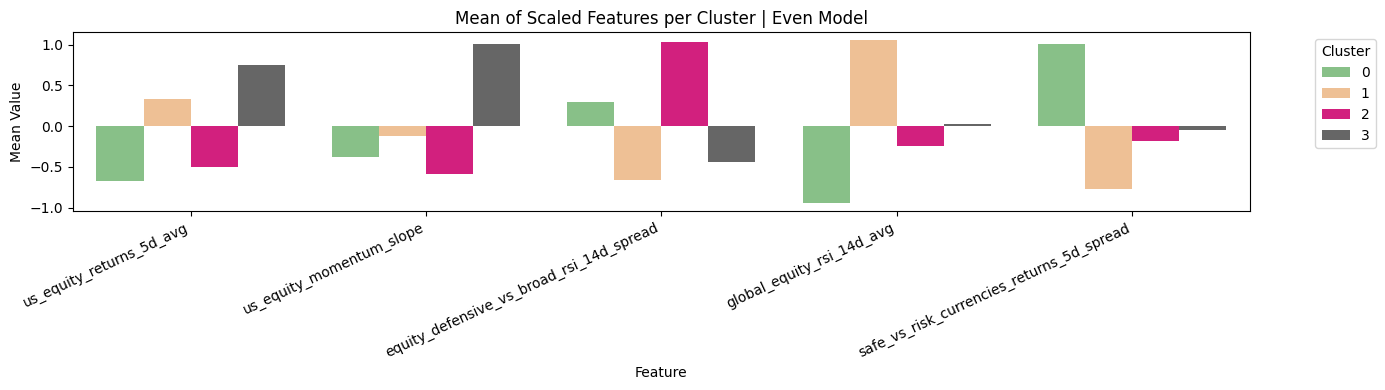

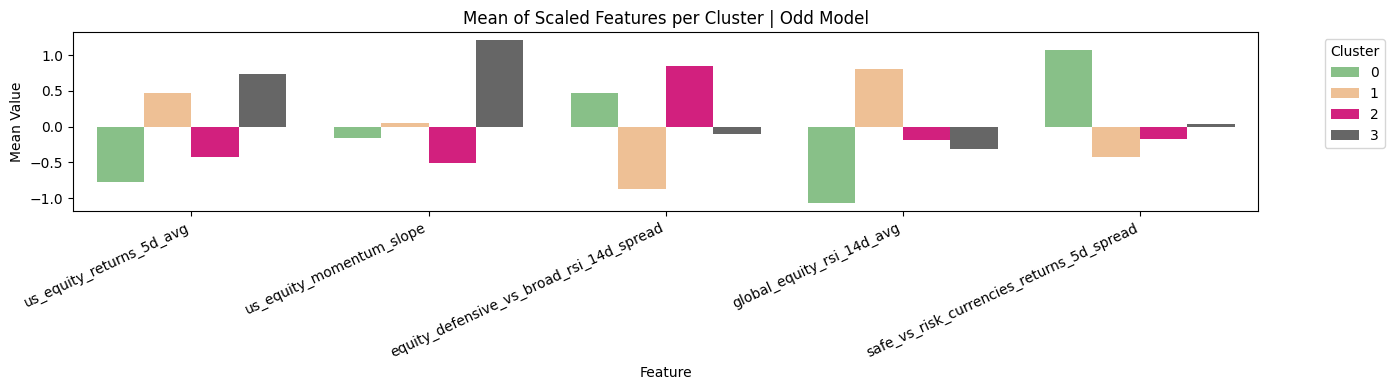

C:\Users\sergi\AppData\Local\Temp\ipykernel_2832\3692880853.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')


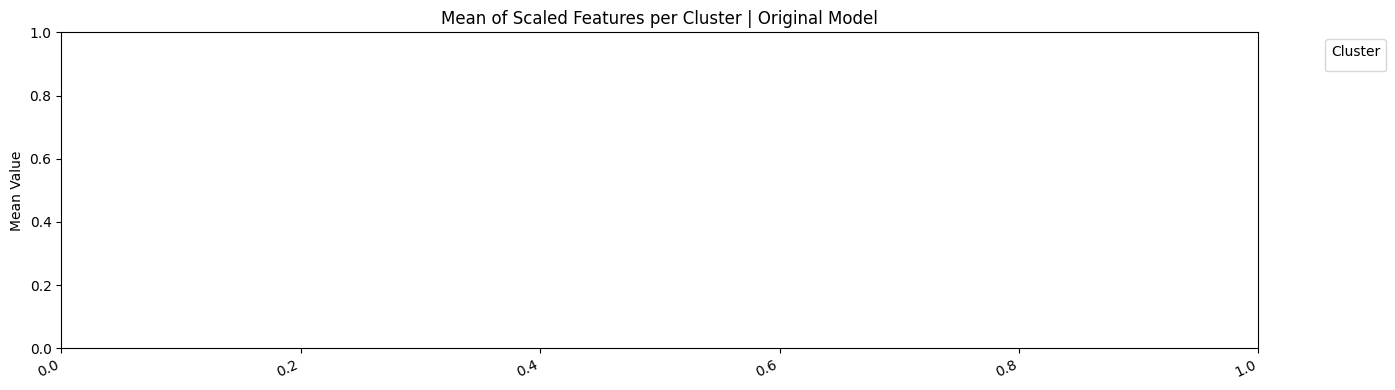

In [31]:
## EVEN
df_interpret = pd.DataFrame(even_scaled, columns=even_rows.columns, index=even_rows.index)
# Assign cluster labels
df_interpret['Cluster'] = even_gmm_labels

# Calculate mean value per feature per cluster
mean_per_cluster = df_interpret.groupby('Cluster').mean().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(14, 4))
sns.barplot(x='Feature', y='Mean', hue='Cluster', data=melted, palette=cluster_palette)

plt.title('Mean of Scaled Features per Cluster | Even Model')
plt.ylabel('Mean Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=25, ha='right') # Rotate by 45 degrees, align right
plt.tight_layout()
plt.show()

## ODD
df_interpret = pd.DataFrame(odd_scaled, columns=odd_rows.columns, index=odd_rows.index)
# Assign cluster labels
df_interpret['Cluster'] = odd_gmm_labels

# Calculate mean value per feature per cluster
mean_per_cluster = df_interpret.groupby('Cluster').mean().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(14, 4))
sns.barplot(x='Feature', y='Mean', hue='Cluster', data=melted, palette=cluster_palette)

plt.title('Mean of Scaled Features per Cluster | Odd Model')
plt.ylabel('Mean Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=25, ha='right') # Rotate by 45 degrees, align right
plt.tight_layout()
plt.show()

## original
df_interpret = pd.DataFrame(orginal_trend_scaled, columns=df_pivot_clean.columns, index=df_pivot_clean.index)
# Assign cluster labels
df_interpret['Cluster'] = orginal_trend_gmm_labels

# Calculate mean value per feature per cluster
mean_per_cluster = df_interpret.groupby('Cluster').mean().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Mean')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(14, 4))
sns.barplot(x='Feature', y='Mean', hue='Cluster', data=melted, palette=cluster_palette)

plt.title('Mean of Scaled Features per Cluster | Original Model')
plt.ylabel('Mean Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=25, ha='right') # Rotate by 45 degrees, align right
plt.tight_layout()
plt.show()


In [32]:
is_equal = (even_gmm_labels[:-1] == odd_gmm_labels)
print("% of day labelled as same cluster", round(is_equal.sum()/len(is_equal)*100, 2))

% of day labelled as same cluster 63.58


In [33]:
# create an empty array of the right size
combined = np.empty(even_gmm_labels.size + odd_gmm_labels.size, dtype=even_gmm_labels.dtype)

# place even and odd labels in the right positions
combined[::2] = even_gmm_labels  # positions 0, 2, 4, ...
combined[1::2] = odd_gmm_labels   # positions 1, 3, 5, ...

combined.shape, orginal_trend_gmm_labels.shape

((2181,), (2181,))

In [34]:
is_equal = (combined == orginal_trend_gmm_labels)
print("% of day labelled as same cluster", round(is_equal.sum()/len(is_equal)*100, 2))

% of day labelled as same cluster 70.75


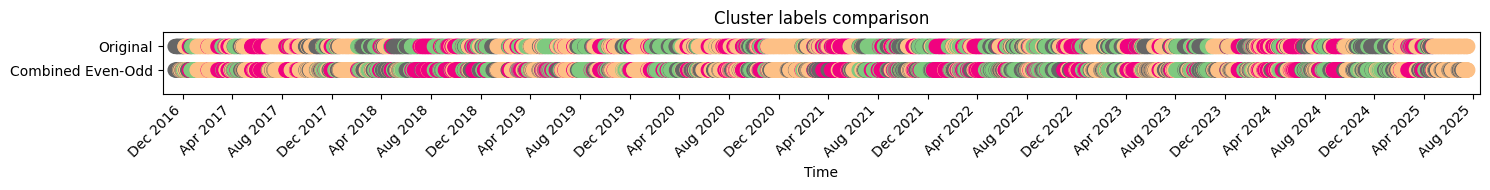

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

T = len(combined)
time = df_pivot_clean.index  # Use timestamp index directly

fig, ax = plt.subplots(figsize=(15, 2))

# Combined labels (y=0)
ax.scatter(time, np.zeros(T), c=[cluster_palette[l] for l in combined], s=100, label="Combined")

hspace = 0.5
# Original labels (y=hspace)
ax.scatter(time, np.ones(T)*hspace, c=[cluster_palette[l] for l in orginal_trend_gmm_labels], s=100, label="Original")

pad = pd.Timedelta(days=30)  # change days to taste
ax.set_xlim(time[0] - pad, time[-1] + pad)
ax.set_ylim(-0.5, 0.8)

# Y-axis labels
ax.set_yticks([0, hspace])
ax.set_yticklabels(["Combined Even-Odd", "Original"])

# X-axis formatting for dates
ax.set_xlabel("Time")
ax.set_title("Cluster labels comparison")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()
